In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# Import Packages

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # Color blind friendly palette
import matplotlib.font_manager # Use times new roman font

from astropy import coordinates as coord # to compute XYZ cartesian coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation

from sklearn.neighbors import KernelDensity # used to perform kde

from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess # used for lowess

import scipy.integrate # to bootstrap the lowess fit
import scipy.stats as st 

# Load the dataset

### Target Sample from Gaia Archive cross-matched with golden OBA sample

#### Photometric and Astrometric filters:

Angular Distance between the two sources (EDR3 and 2MASS)
* <font size="3"> xmatch.angular_distance $<$ 1</font>

* <font size="3">$ G < 16.0 $</font>

We define a proxy for the absolute magnitude of a star in the $K_s$ band, $M̃_{Ks}$ , and we require $M̃_{Ks} < 0$. This translates to the
following parallax condition:

* <font size="3">$\bar\omega < 10^{(10-K_s-0.0)/5}$</font>

The first condition excludes most of the red sources, the second
condition removes sources with unnaturally blue colours

* <font size="2"> $(J − K_s ) − 0.25(G − K_s ) < 0.1$ mag</font>
* <font size="2"> $(J − K_s ) − 0.25(G − K_s ) > -0.3$ mag</font>

O and B-type stars lie on a sequence in
the J − H vs. G − $K_s$ colour-colour diagram as a consequence
of interstellar reddening and are clearly separated from redder
turn-off stars and giants.

* <font size="2"> $(J − H) < 0.15(G − K_s) + 0.05$ </font>
* <font size="2"> $(J − H) < 0.15(G − K_s) - 0.15$</font>

Finally, we select stars in the G vs. G− $K_s$ colour-magnitude diagram, where giants still contaminating our sample can be easily separated from OB

* <font size="2"> $G > 2(G − K_s ) + 3$</font>

In [3]:
df = pd.read_csv('DR3_Target_Sample.csv') 
print('The columns in the data file:')
print(df.columns)
print('The target sample contains ' + str(len(df)) + ' sources')
df.head()

The columns in the data file:
Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pm', 'pmra',
       'pmdec', 'ruwe', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'radial_velocity', 'j_m', 'h_m', 'ks_m',
       'vtan_flag', 'teff_gspphot', 'teff_esphs', 'spectraltype_esphs',
       'ag_esphs', 'ebpminrp_esphs', 'r_med_photogeo', 'fidelity_v2'],
      dtype='object')
The target sample contains 392407 sources


,source_id,ra,dec,parallax,parallax_error,pm,pmra,pmdec,ruwe,phot_g_mean_mag,...,h_m,ks_m,vtan_flag,teff_gspphot,teff_esphs,spectraltype_esphs,ag_esphs,ebpminrp_esphs,r_med_photogeo,fidelity_v2
0,243372470701845760,57.638948,43.192354,0.106499,0.022242,0.755412,0.537039,0.531259,1.055916,14.544296,...,13.663,13.587,0,13554.185,14835.984,B,1.625442,0.882740,5688.1694,0.981445
1,243379269631092992,57.876688,43.260404,1.183190,0.019498,7.758392,6.581542,-4.108035,1.158547,10.655185,...,9.571,9.486,0,NaN,11288.831,B,1.584971,0.857766,827.2378,1.000000
2,243398618462226304,57.715808,43.550199,0.344593,0.016701,0.421524,-0.192663,-0.374918,1.074759,13.462626,...,12.075,11.965,0,9209.222,NaN,B,NaN,NaN,2586.8064,1.000000
3,5637698390562302976,138.880643,-27.535364,0.086047,0.027991,3.283717,-2.014202,2.593412,0.967602,15.466593,...,14.622,14.673,1,8330.014,8904.132,A,0.724680,0.386567,6761.7900,1.000000
4,243435211583692160,57.065159,43.581423,0.162944,0.027606,0.521912,0.502950,-0.139402,1.035297,14.914671,...,13.596,13.465,0,9000.795,8509.717,A,1.486240,0.801479,4869.9760,0.997559


# Select only OBA stars

In [4]:
df.groupby('spectraltype_esphs').spectraltype_esphs.count()

spectraltype_esphs
A          134874
B          249105
F            2657
G             530
K              61
M               5
O            3947
unknown      1143
Name: spectraltype_esphs, dtype: int64

In [6]:
df = df[(df.spectraltype_esphs == 'O') | 
       (df.spectraltype_esphs == 'B') |
       (df.spectraltype_esphs == 'A')
       ]
df.groupby('spectraltype_esphs').spectraltype_esphs.count()

spectraltype_esphs
A    134874
B    249105
O      3947
Name: spectraltype_esphs, dtype: int64

# Compute XYZ spatial components for each source

#### Transform ICRS coordinates (ra, dec) -> Galactic coordinates (l,b)

In [8]:
# Create an object (ra,dec) in degrees
sc = SkyCoord(ra = df["ra"], dec = df["dec"], unit = "deg", frame = "icrs") 
# Transform to galactic reference frame (l,b)
gc = sc.transform_to('galactic')

# Create the lists for each coordinate
l_list = np.array(gc.l.value) # value retira os valores em unidades
b_list = np.array(gc.b.value) # é necessário para não dar erro depois com funções do numpy

# Add the lists to the dataframe
df["l"] = l_list
df["b"] = b_list

gc

<SkyCoord (Galactic): (l, b) in deg
    [(154.21662074, -8.53850539), (154.3082056 , -8.3759227 ),
     (154.03093531, -8.22637073), ..., (346.57218926, -3.63175464),
     (346.5571998 , -3.59134033), (346.5835029 , -3.55762093)]>

#### Transform galactic coordinates (l, b, dist) -> Cartesian galactocentric coordinates (x,y,z)

In [10]:
# photogeometric distances from Bailer-Jones, 2021. Use this by default
distance = (df.r_med_photogeo / 1000) # distances in kpc
distance.unit = 'kpc'

In [12]:
# Create the 3d galactic object
xyzc = SkyCoord(l = l_list * u.deg, b = b_list * u.deg , distance = distance,  frame = 'galactic') # usar esta qd nao se usam filtros

# Transform into cartesian representation
xyzc.representation_type = CartesianRepresentation

# (u,v,w) = (x,y,z) = (8,0,0) represents the center of the galaxy
xyzc

<SkyCoord (Galactic): (u, v, w) in kpc
    [(-5.06511423,  2.44675945, -0.8445455 ),
     (-0.73750503,  0.35480713, -0.12050149),
     (-2.30168862,  1.12107059, -0.37013182), ...,
     ( 1.43511001, -0.34262764, -0.09364805),
     ( 2.90142337, -0.69350734, -0.18723151),
     ( 2.30578674, -0.55001752, -0.14737772)]>

In [13]:
x_list = np.array(xyzc.u.value)
y_list = np.array(xyzc.v.value)
z_list = np.array(xyzc.w.value)

x_list = x_list[~np.isnan(x_list)]
y_list = y_list[~np.isnan(y_list)]
z_list = z_list[~np.isnan(z_list)]

# Perform Kernel Density Estimation (KDE)

#### Represent the spiral arm structure of the Milky Way around the Sun (X,Y) = (0,0) kpc

In [15]:
# Create domain for score samples 
xmatrix, ymatrix = np.mgrid[-5:5:121j, -5:5:121j] # overdensity plots

matrix = np.vstack([xmatrix.ravel(), ymatrix.ravel()])

# np.vstack - Stack arrays in sequence vertically (row wise)
values = np.vstack([x_list, y_list])

# Create domain to perform kde
xvalues = np.linspace(-5, 5, 121)
yvalues = np.linspace(-5, 5, 121)

np.save('xvalues.npy', xvalues)
np.save('yvalues.npy', yvalues)

In [16]:
def f(bw , i):
    kernel = KernelDensity(kernel='epanechnikov', bandwidth = bw) # choose kernel and bw

    kernel.fit(values.T) # Fit the Kernel Density model on the data.
    
    log_prob = kernel.score_samples(matrix.T) # Compute the log-likelihood of each sample under the model
    
    prob = np.exp(log_prob) # obtain probability
    
    dens_grid = np.reshape(prob, xmatrix.shape) # reshape into a density matrix
    
    np.save('local_dens_grid_square{}.npy'.format(i), dens_grid) # save file
    
bw_list = [0.2, 0.5, 1.5, 2.] # kernel bw to be used

for x in bw_list:
    filename = x
    f(x,filename)

#### Load the density matrix 
##### Note: Choose which to load

In [23]:
dens_200pc = np.load('local_dens_grid_square0.2.npy')
#dens_500pc = np.load('local_dens_grid_square0.5.npy')

#dens_1500pc = np.load('local_dens_grid_square1.5.npy')
dens_2000pc = np.load('local_dens_grid_square2.0.npy')

#### Remove regions with low statistics and calculate overdensity

In [26]:
dens_200pc = np.where( dens_200pc < 0.003, -1, dens_200pc)
#dens_500pc = np.where( dens_500pc < 0.003, -1, dens_500pc)

ov200_2000 = (dens_200pc / dens_2000pc) - 1 # overdensity
#ov500_1500 = (dens_500pc / dens_1500pc) - 1

# Map the spiral arm structure

### Customize a color-blind friendly palette

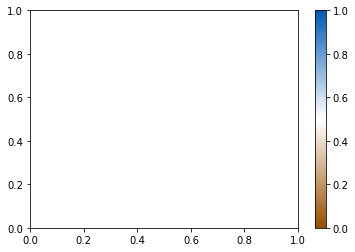

In [33]:
# Define two main colors for the diverging palette
main_colors = [(153/255, 79/255, 0/255), 
               (0/255, 90/255, 181/255)]

# Generate shades of the two main colors for the diverging palette
n_shades = 50
colors1 = np.linspace(main_colors[0], [1, 1, 1], n_shades)

colors2 = np.linspace(main_colors[1], [1, 1, 1], n_shades)
arr_reversed = colors2[::-1]

colors = np.vstack((colors1, arr_reversed))

# Create the diverging palette using the ListedColormap class
diverging_palette = ListedColormap(colors)

# Plot a colorbar to show the diverging colorblind-friendly palette
plt.colorbar(plt.cm.ScalarMappable(cmap=diverging_palette))
plt.show()

hide_toggle()

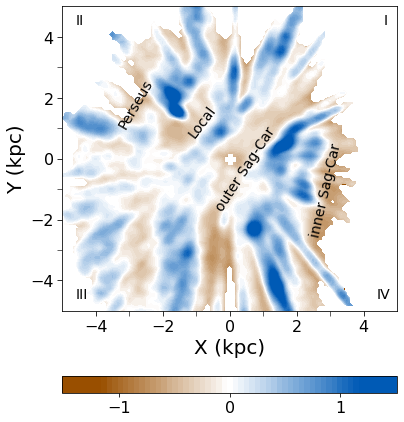

In [38]:
#for horizontal colorbar
fgsize=(6,8.)
fig = plt.figure(figsize=fgsize)
ax = fig.gca()

iniz=-2.1
fin = 2.8
N_levels=100
levels=np.linspace(iniz,fin,N_levels)

cset1 = ax.contourf(xvalues, 
                    yvalues,
                    ov200_2000.T, 
                    levels= levels,
                    cmap=diverging_palette,
                    vmin=-1.18, 
                    vmax = 1.18)


cbar=plt.colorbar(mappable=cset1,
                  orientation="horizontal", 
                  ticks = [-1, 0, 1])
cbar.ax.set_xlim(-1.51,1.51)
cbar.ax.tick_params(labelsize=16) 

ax.set_xlabel('X (kpc)', fontsize=20)
ax.set_ylabel('Y (kpc)', fontsize=20)

Xmin, Xmax = -5, 5
Ymin, Ymax = -5, 5
ax.set_xlim([Xmin,Xmax])
ax.set_ylim([Ymin,Ymax])
ax.tick_params(axis="x", labelsize=16, length = 5, which = 'both')
ax.set_xticks([-3, -1, 1, 3], minor=True)
ax.tick_params(axis="y", labelsize=16, length = 5, which = 'both')
ax.set_yticks([-3, -1, 1, 3], minor=True)
ax.plot([0,0],[0,0],marker='P',c='white',markersize=10) # Sun's position


# Annotate the location of the spiral arms
# inner Carina
ax.annotate('inner Sag-Car', xy=(2.35, -2.5), rotation=77, color = 'black', 
            fontsize = 14, fontname = 'Times New Roman')
# outer Carina
ax.annotate('outer Sag-Car', xy=(-0.5, -1.7), rotation=57, color = 'black', 
            fontsize = 14, fontname = 'Times New Roman')
# Local
ax.annotate('Local', xy=(-1.3, 0.7), rotation=53, color = 'black', 
            fontsize = 14, fontname = 'Times New Roman')

# Perseus
ax.annotate('Perseus', xy=(-3.4, 1.), rotation=60, color = 'black', 
            fontsize = 14, fontname = 'Times New Roman')

# Annotate the location of the Galactic quadrants
ax.annotate(r'I', xy=(4.6, 4.4), color = 'black', fontsize = 14, fontname = 'Times New Roman')
ax.annotate(r'II', xy=(-4.6, 4.4), color = 'black', fontsize = 14, fontname = 'Times New Roman')
ax.annotate(r'III', xy=(-4.6, -4.6), color = 'black', fontsize = 14, fontname = 'Times New Roman')
ax.annotate(r'IV', xy=(4.4, -4.6), color = 'black', fontsize = 14, fontname = 'Times New Roman')
    
plt.show()

# Use LOWESS to obtain extinction profiles along certain lines-of-sight

### bootstrapping to provide an estimate of the spread of the curve

In [48]:
def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), int(len(x)/2), replace=True) #np.random.choice(ARRAY, size)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm_lowess(y_s,
                     x_s, 
                     frac=1./5., 
                     it=5,
                     return_sorted = False)
    
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, 
                                        y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

### Profile for  309º < l < 311º

/home/goncalo/miniconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


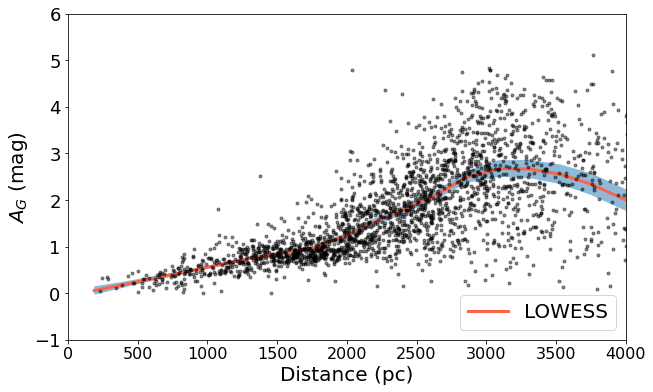

In [56]:
reg = df[(df.l > 309) & (df.l < 311)]

x = np.array(reg['r_med_photogeo']) # x values
y = np.array(reg['ag_esphs']) # y values

xgrid = np.linspace(x.min(),x.max())
K = 100 # run smooth K times
smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T # holds every smooth

plt.figure(figsize = (10, 6))
mean = np.nanmean(smooths, axis=1) # mean of the smooth fit
stderr = scipy.stats.sem(smooths, axis=1) # 
stderr = np.nanstd(smooths, axis=1, ddof=0)

plt.fill_between(xgrid, 
                 mean-1.96*stderr,
                 mean+1.96*stderr, 
                 alpha=0.5)

plt.plot(xgrid, mean, color='tomato', lw = 3, label = 'LOWESS')
plt.plot(x, y, 'k.', alpha = 0.45)

plt.xlim(0, 4000)
plt.ylim(-1, 6)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 18)
plt.xlabel('Distance (pc)', fontsize = 20)
plt.ylabel(r'$A_G$ (mag)', fontsize = 20)
plt.legend(loc = 4, fontsize = 20)